Load dependencies and change number of rows outputed 

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
pd.options.display.max_rows = 10
%matplotlib inline
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [3]:
df = pd.read_csv("honorsapps.csv",index_col=0)

Load files

The App Score is built on a number of components including an already scaled and weighted scoring of SAT
and/or ACT scores so let's see how the two correlate.

In [10]:
df.dropna(how='all',inplace=True)
df.reset_index(drop=['Index'],inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 797 entries, 0 to 796
Data columns (total 3 columns):
Gender    790 non-null object
App       792 non-null object
Offer     797 non-null object
dtypes: object(3)
memory usage: 18.8+ KB


In [11]:
df['App'] = df['App'].fillna('0')
app = {'?':'0','#VALUE!':'0'}
df['App'] = df['App'].replace(app)

Establishing naming consistencies

In [12]:
offer = {'OFFER':'Offer','REJECT':'Reject'}
gender = {'Female':'F','Male':'M','Unknown':'U'}

In [13]:
df['Offer'] =df['Offer'].replace(offer)
df['Gender'] = df['Gender'].replace(gender)
df['App'] = df['App'].astype(float)
df.shape

(797, 3)

In [14]:
missing=df.isnull().sum().sum()
def manage_missing(missing):
    if missing/(df.shape[0]) < 0.05:
        print('Only {} rows were removed from the dataset.'.format(df.isnull().sum().sum()))
        return df.dropna(how='any',axis=0,inplace=True)
    print('Too much data would be lost.')
manage_missing(missing)

Only 7 rows were removed from the dataset.


In [15]:
df.reset_index(inplace=True)

Visualize the data

/Users/Casey/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


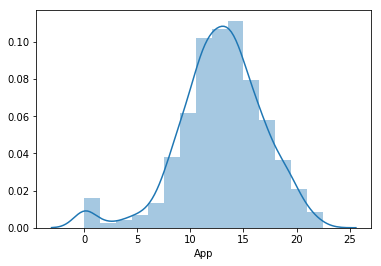

In [16]:
sns.distplot(df['App'],bins=15)

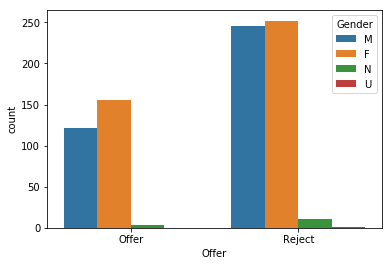

In [17]:
sns.countplot(df['Offer'],hue=df['Gender'])

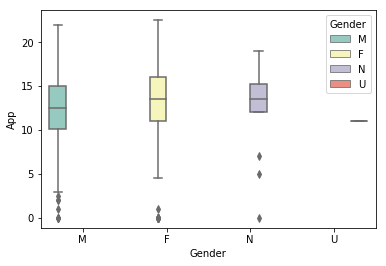

In [18]:
sns.boxplot(x="Gender",y='App',data=df,orient='v',hue='Gender',palette='Set3')

Transform the data.

In [19]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [20]:
df['Gender'] = le.fit_transform(df.Gender.astype(str))
df['Offer'] = le.fit_transform(df.Offer.astype(str))
df.dtypes
df.head()

,index,Gender,App,Offer
0,0,1,0.0,0
1,1,0,0.0,0
2,2,2,0.0,0
3,3,0,0.0,0
4,4,0,0.0,0


In [21]:
X = df.iloc[:,0:-1].values
y = df.iloc[:,-1]

Setup pipeline to try out various classification techniques

In [22]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score

/Users/Casey/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [23]:
scaler = StandardScaler()

In [24]:
pipeline = Pipeline([
    ('normalizer',StandardScaler()),
    ('clf',LogisticRegression())
])
pipeline.steps

[('normalizer', StandardScaler(copy=True, with_mean=True, with_std=True)),
 ('clf',
  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
            intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
            penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
            verbose=0, warm_start=False))]

In [25]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=123)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(553, 3)
(237, 3)
(553,)
(237,)


In [26]:
scores = cross_validate(pipeline, X_train, y_train)
scores['test_score'].mean() * 100

72.51762632197415

Better than just guessing, but needs works. Time to do some cross validation on the pipeline...look for algo with best test_score

In [27]:
clfs = []
clfs.append(LogisticRegression())
clfs.append(SVC())
clfs.append(KNeighborsClassifier(n_neighbors=3))
clfs.append(DecisionTreeClassifier())
clfs.append(RandomForestClassifier())
clfs.append(GradientBoostingClassifier())

In [28]:
for classifier in clfs:
    pipeline.set_params(clf=classifier)
    scores=cross_validate(pipeline,X_train,y_train)
    print('xxxxxxxxxxxxxxxxxxx')
    print(str(classifier))
    print('xxxxxxxxxxxxxxxxxxx')
    for key, values in scores.items():
        print(key,'mean: ',values.mean())
        print(key,'standard deviation: ',values.std())
    

xxxxxxxxxxxxxxxxxxx
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
xxxxxxxxxxxxxxxxxxx
fit_time mean:  0.0019117991129557292
fit_time standard deviation:  0.0001462085075663932
score_time mean:  0.0004886786142985026
score_time standard deviation:  5.775878369206308e-06
test_score mean:  0.7251762632197415
test_score standard deviation:  0.040929483843214313
train_score mean:  0.7459447782883625
train_score standard deviation:  0.029604059680100648
xxxxxxxxxxxxxxxxxxx
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
xxxxxxxxxxxxxxxxxxx
fit_time mean:  0.006718079249064128
fit_time standard deviation

#Wow..an improvement of nearly 14% (random state may not be set) with the Decision Tree...time to optimize some more.

In [34]:
dtc = DecisionTreeClassifier()

In [35]:
dtc.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [36]:
y_pred = dtc.predict(X_test)

In [37]:
dtc.score(X_test,y_test)

0.810126582278481

In [38]:
from sklearn.metrics import classification_report

In [39]:
print(classification_report(y_test,y_pred))

             precision    recall  f1-score   support

          0       0.68      0.80      0.74        79
          1       0.89      0.82      0.85       158

avg / total       0.82      0.81      0.81       237



In [40]:
from sklearn.metrics import confusion_matrix

In [41]:
confusion_matrix(y_test,y_pred)

array([[ 63,  16],
       [ 29, 129]])

In [42]:
y_pred_prob = dtc.predict_proba(X_test)[:,1]

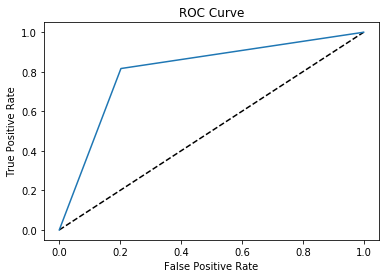

In [43]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate') 
plt.title('ROC Curve')
plt.show()

Where to go from here?